<a href="https://colab.research.google.com/github/fiapdatanalytics/tech-challenge4/blob/main/tech_challenge_4_data_viz_and_production_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tech Challenge 4 - Data viz and production models**

## **Desafio**

🎯 Objetivo do Projeto

Desenvolver um modelo preditivo de Machine Learning para auxiliar uma equipe médica a diagnosticar níveis de nivel_obesidade em pacientes, com assertividade mínima de 75%, deployado em uma aplicação Streamlit, acompanhado de dashboard analítico e vídeo de apresentação.

🧩 Entregáveis Principais

* Pipeline de Machine Learning
* Feature engineering, treinamento e avaliação do modelo.
* Modelo com acurácia ≥ 75%
* Deploy no Streamlit
* Aplicação funcional acessível por link público.
* Dashboard analítico
* Visualização dos principais insights.
* Documentação (.doc ou .txt)
* Links do app, dashboard e repositório GitHub.
* Vídeo de apresentação (4 a 10 minutos)


# **Bibliotecas**

In [203]:
import pandas as pd
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
import numpy as np


# **Funções**

## **Dicionario dados**

In [204]:
def criar_novo_dicionario_dados(df: pd.DataFrame) -> dict:
    """
    Cria um novo dicionário de dados com uma estrutura inicial para cada coluna do DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão usadas para criar o dicionário.

    Returns:
        dict: O novo dicionário de dados.
    """
    try:
        novo_dicionario = {}
        for coluna in df.columns:
            novo_dicionario[coluna] = {
                'nome_original': coluna,
                'tipo_coluna': 'original',
                'novo_nome': None,
                'descricao': None,
                'transformacao': None
            }
        print("Novo dicionário de dados criado.")
        return novo_dicionario
    except Exception as e:
        print(f"Ocorreu um erro ao criar o novo dicionário de dados: {e}")
        return None

### **Atualiza de forma manual das colunas do dicionario de dados**

In [205]:
def atualizar_campo_dicionario(dicionario: dict, coluna: str, campo: str, novo_valor):
    """
    Atualiza um campo específico para uma coluna no dicionário de dados.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        coluna (str): O nome da coluna (chave no dicionário) cujo campo será atualizado.
        campo (str): O nome do campo a ser atualizado ('nome_original', 'novo_nome', 'descricao', 'transformacao').
        novo_valor: O novo valor para o campo especificado.
    """
    try:
        if coluna in dicionario:
            if campo == 'nome_original':
                print(f"Erro: Não é permitido atualizar o campo 'nome_original'.")
            elif campo in dicionario[coluna]:
                # Tratamento especial para 'transformacao' se o novo valor for um dicionário
                if campo == 'transformacao' and isinstance(novo_valor, dict):
                    if not isinstance(dicionario[coluna][campo], dict):
                         dicionario[coluna][campo] = {} # Inicializa se ainda nao for um dicionario
                    # Adiciona novos pares de chave-valor de novo_valor ao dicionário transformacao existente
                    for key, value in novo_valor.items():
                        dicionario[coluna][campo][key] = value
                    print(f"Campo '{campo}' da coluna '{coluna}' atualizado com novos itens.")

                else:
                    dicionario[coluna][campo] = novo_valor
                    print(f"Campo '{campo}' da coluna '{coluna}' atualizado para: '{novo_valor}'")
            else:
                print(f"Erro: O campo '{campo}' não existe para a coluna '{coluna}' no dicionário de dados.")
        else:
            print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados.")
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o campo '{campo}' para a coluna '{coluna}': {e}")

### **Atualiza nomes dicionario**

In [206]:
def atualizar_dicionario_renomeacao(dicionario: dict, mapa_colunas: dict):
    """
    Atualiza o dicionário de dados com base nas renomeações de colunas aplicadas.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        mapa_colunas (dict): Dicionário com o mapeamento de renomeação de colunas (nome_original: novo_nome).
    """
    try:
        print("Iniciando a atualização do dicionário de dados com renomeações...")

        # Crie uma copia das chaves para iterar sem problemas ao modificar o dicionário original
        chaves_originais = list(dicionario.keys())

        # Processar entradas e renomeacoes existentes
        for chave_original in chaves_originais:
            if chave_original in dicionario: # Verifica se a chave ainda existe
                info = dicionario[chave_original]
                nome_original = info.get('nome_original')
                novo_nome_existente = info.get('novo_nome') # Obtem o novo_nome potencialmente existente

                # Verifica se o nome da coluna original está no mapa de renomeação
                if nome_original in mapa_colunas:
                    atualiza_novo_nome = mapa_colunas[nome_original]

                   # Se a chave atual no dicionário não for o novo nome do mapa,
                   # e ainda não estiver definida com um novo nome diferente, atualize a chave e as informacoes.
                   # Esta condição lida tanto com renomeações iniciais quanto com casos em que uma coluna recebeu
                   # manualmente um novo_nome antes da aplicação do mapa de renomeacao.
                    if chave_original != atualiza_novo_nome and (novo_nome_existente is None or novo_nome_existente != atualiza_novo_nome):
                         # Copie as informacoes para a nova chave antes de excluir a antiga
                         dicionario[atualiza_novo_nome] = dicionario.pop(chave_original)
                         info = dicionario[atualiza_novo_nome] # Update info to point to the new key


                    info['novo_nome'] = atualiza_novo_nome # Atualiza novo_nome no dicionário info


                    # Certifica de que 'transformacao' seja um dicionário
                    if not isinstance(info.get('transformacao'), dict):
                        info['transformacao'] = {}
                    # Adiciona transformacao de renomeacao se ainda nao estiver presente
                    renome_desc = f"Renomeada de '{nome_original}' para '{atualiza_novo_nome}'."
                    if renome_desc not in info['transformacao'].values():
                         transform_key = f"transformacao_{len(info['transformacao']) + 1}"
                         info['transformacao'][transform_key] = renome_desc
                # Se a coluna nao estiver em mapa_colunas, mas tiver um novo_nome, certifique-se de que a chave do dicionario seja o novo_nome
                # Esta parte pode ser menos relevante para uma funcao de renomeacao dedicada, mas mantendo
                # uma verificacao do novo_nome existente para garantir a consistência do dicionario.
                elif novo_nome_existente is not None and chave_original != novo_nome_existente:
                     # Se a chave atual nao corresponder ao novo_nome existente, atualize a chave
                     if novo_nome_existente in dicionario:
                          # indica se um conflito ou erro nas etapas anteriores
                          print(f"Aviso: Conflito ao renomear. '{chave_original}' tem novo_nome '{novo_nome_existente}', mas '{novo_nome_existente}' já existe no dicionário.")
                     else:
                          dicionario[novo_nome_existente] = dicionario.pop(chave_original)
                          info = dicionario[novo_nome_existente] # Atualiza informacao para apontar para a nova chave


        print("Dicionário de dados atualizado com renomeações.")
        # dicionario modicado inplace
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com renomeações: {e}")


### **Atualiza Dicionario com as novas colunas criadas**

In [207]:
def atualizar_dicionario_novas_colunas(dicionario: dict, df: pd.DataFrame):
    """
    Atualiza o dicionário de dados com informações sobre colunas recém-criadas no DataFrame.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        df (pd.DataFrame): O DataFrame com as colunas recém-criadas.
    """
    print("Iniciando a atualização do dicionário de dados com novas colunas...")
    try:
        colunas_atuais = df.columns.tolist()
        # Encontra colunas no DataFrame que não estão presentes no dicionário por seu 'novo_nome'
        existing_novo_nomes = [info.get('novo_nome') for info in dicionario.values() if info.get('novo_nome')]
        novas_colunas = [col for col in colunas_atuais if col not in existing_novo_nomes]

        for nova_coluna in novas_colunas:
            # Adiciona uma nova entrada ao dicionário para a nova coluna
            if nova_coluna not in dicionario: # Evita adicionar se existir uma chave com o mesmo nome
                dicionario[nova_coluna] = {
                    'nome_original': nova_coluna,
                    'tipo_coluna' : 'criada',
                    'novo_nome': None,
                    'descricao': None,
                    'transformacao': None
                }
                print(f"Adicionada nova coluna '{nova_coluna}' ao dicionário de dados.")
            else:

                 print(f"Coluna '{nova_coluna}' já existe no dicionário de dados.")


        print("Dicionário de dados atualizado com novas colunas.")
        return dicionario # Retorna explicitamente o dicionário atualizado
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário com novas colunas: {e}")
        return None # Retorna Nenhum em caso de erro

### **Atualiza campo descricao do dicionario em lote**

In [208]:
def atualizar_descricoes_dicionario(dicionario: dict, descricoes: dict):
    """
    Atualiza o campo 'descricao' no dicionário de dados com base em um dicionário de descrições.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        descricoes (dict): O dicionário contendo as descrições (chave: nome da coluna, valor: descrição).

    Returns:
        int: A quantidade de descrições atualizadas.
    """
    quantidade_linhas_atualizadas = 0
    try:

        if not isinstance(descricoes, dict):
            print("Erro: O argumento 'descricoes' deve ser um dicionário.")
            return 0

        for chave in dicionario:
            if chave in descricoes:

                atualizar_campo_dicionario(dicionario, chave, 'descricao', descricoes[chave])
                quantidade_linhas_atualizadas += 1

        print(f'Quantidade de descrições atualizadas: {quantidade_linhas_atualizadas}.')
        return quantidade_linhas_atualizadas
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar as descrições no dicionário: {e}")
        return 0 # # Retorna 0 ou gera novamente a exceca




## **Funções de Transformação**

### **Renomear Colunas**

In [209]:
def renomear_colunas(df: pd.DataFrame, mapa_renomeacao: dict = None, dicionario: dict = None) -> None:
    """
    Renomeia as colunas de um DataFrame utilizando um dicionário fornecido
    ou aplicando um padrão de formatação (minúsculas, espaços por '_').
    Se o padrão de formatação for aplicado, o dicionário de mapeamento gerado
    é salvo em um arquivo JSON chamado 'renaming_map_pattern.json'.
    Opcionalmente, atualiza um dicionário de dados com as renomeações.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão renomeadas.
        mapa_renomeacao (dict, optional): Um dicionário mapeando nomes de colunas originais para novos nomes.
                                         Se None, um padrão de formatação será aplicado.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    colunas_originais = df.columns.tolist()
    num_linhas_antes, num_colunas_antes = df.shape

    print("Número de linhas e colunas antes da transformação:")
    print(f"Linhas: {num_linhas_antes}, Colunas: {num_colunas_antes}")
    print(f"\nNomes das colunas originais:\n{colunas_originais}\n")

    try:
        if mapa_renomeacao:
            # Verificar se o dicionário fornecido tem chaves que correspondem às colunas do DataFrame
            if any(col in mapa_renomeacao for col in colunas_originais):
                df.rename(columns=mapa_renomeacao, inplace=True) # Modifica in-place
                print("Utilizado dicionário de renomeação fornecido.")
            else:
                print("Dicionário de renomeação fornecido, mas nenhuma chave corresponde às colunas existentes.")
                print("Aplicando padrão de formatação como alternativa.")
                # Aplicar padrão se o dicionário não corresponder
                mapa_nova_coluna = {}
                nova_coluna = []
                for col in colunas_originais:
                    col_caixa_baixa = col.lower()
                    col_limpa = col_caixa_baixa.strip()
                    col_formatada = re.sub(r'\s+', '_', col_limpa)
                    nova_coluna.append(col_formatada)
                    mapa_nova_coluna[col] = col_formatada
                df.columns = nova_coluna # Modifica in-place
                print("Padrão de formatação aplicado.")
                # Salva mapa gerado em JSON
                with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                    json.dump(mapa_nova_coluna, f, indent=4)
                print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")
                # Usa o mapa gerado para atualização do dicionário
                mapa_renomeacao_aplicado = mapa_nova_coluna
        else:
            # Aplicar padrão de formatação se nenhum dicionário for fornecido
            print("Nenhum dicionário de renomeação fornecido. Aplicando padrão de formatação.")
            mapa_nova_coluna = {}
            nova_coluna = []
            for col in colunas_originais:
                col_caixa_baixa = col.lower()
                col_limpa = col_caixa_baixa.strip()
                col_formatada = re.sub(r'\s+', '_', col_limpa)
                nova_coluna.append(col_formatada)
                mapa_nova_coluna[col] = col_formatada
            df.columns = nova_coluna # Modifica in-place
            print("Padrão de formatação aplicado.")
            # Salva mapa gerado em JSON
            with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                json.dump(mapa_nova_coluna, f, indent=4)
            print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")
            # Usa o mapa gerado para atualização do dicionário
            mapa_renomeacao_aplicado = mapa_nova_coluna


        colunas_modificadas = df.columns.tolist()
        num_linhas_depois, num_colunas_depois = df.shape

        print(f"\nNomes das colunas modificadas:\n{colunas_modificadas}\n")
        print("Número de linhas e colunas após a transformação:")
        print(f"Linhas: {num_linhas_depois}, Colunas: {num_colunas_depois}")

        # Atualizar o dicionário de dados com as renomeações, se fornecido
        if dicionario is not None:
            # Se um mapa_renomeacao específico foi fornecido e usado, use-o para a atualização do dicionário
            # Caso contrário, utilize o mapa_nova_coluna gerado automaticamente (que agora e mapa_renomeacao_aplicado)
            mapa_para_atualizar_dicionario = mapa_renomeacao if mapa_renomeacao and any(col in mapa_renomeacao for col in colunas_originais) else mapa_renomeacao_aplicado

            atualizar_dicionario_renomeacao(dicionario, mapa_para_atualizar_dicionario)


    except NameError as e:
        print(f"Ocorreu um erro de nome ao renomear as colunas: {e}")
    except Exception as e: # Mantendo um except geral para outros tipos de erro inesperados
        print(f"Ocorreu um erro inesperado ao renomear as colunas: {e}")

### **Transforma valores de uma coluna de string para string**

In [210]:
def transformar_valores_string(df: pd.DataFrame, coluna: str, mapa_transformacao: dict, dicionario: dict = None):
    """
    Transforma os valores de uma coluna do tipo string para string utilizando um mapeamento,
    salva a alteração e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser transformada.
        mapa_transformacao (dict): Um dicionário contendo o mapeamento dos valores originais para os novos valores.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"Erro: A coluna '{coluna}' não é do tipo 'object'. Nenhuma transformação será aplicada.")
        return

    try:
        # Verificar se todos os valores únicos na coluna estão no mapeamento
        valores_unicos_na_coluna = df[coluna].dropna().unique()
        valores_nao_mapeados = [valor for valor in valores_unicos_na_coluna if valor not in mapa_transformacao]

        if valores_nao_mapeados:
            print(f"Erro: Os seguintes valores únicos na coluna '{coluna}' não foram encontrados no mapeamento:")
            print(valores_nao_mapeados)
            print("A transformação não será realizada pois nem todos os valores possuem um mapeamento.")
            return # Adicionado para sair da função se houver valores não mapeados


        # Contar linhas antes da alteração
        linhas_antes = df.shape[0]

        # Aplicar a transformação
        df[coluna] = df[coluna].map(mapa_transformacao)

        # Contar linhas após a alteração
        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes # Neste caso, todas as linhas da coluna são "alteradas" pelo mapeamento


        print(f"Coluna '{coluna}' transformada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores string para string.")
        print(f"Número de linhas processadas: {linhas_alteradas}")

        # Exibir valores únicos e contagem depois da transformação
        print(f"\nValores únicos e contagem depois da transformação para a coluna '{coluna}':")
        display(df[coluna].value_counts(dropna=False))

        # Salvar a alteração em uma variável e atualizar o dicionário de dados, se fornecido
        if dicionario is not None:
            alteracao = {
                'tipo': 'mapeamento_string_para_string',
                'mapa_aplicado': mapa_transformacao
            }
            atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)


    except Exception as e:
        print(f"Ocorreu um erro ao transformar a coluna '{coluna}': {e}")

### **Transforma valores de uma coluna de string para numero**

In [211]:
def codificar_coluna_categorica(df: pd.DataFrame, coluna: str, transformacoes_categoricas: list, dicionario: dict = None):
    """
    Transforma os valores únicos de uma coluna do tipo 'object' em números inteiros,
    reutilizando mapeamentos existentes para conjuntos idênticos de valores únicos
    e armazenando novos mapeamentos. Opcionalmente, atualiza um dicionário de dados
    com a transformação realizada.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser codificada.
        transformacoes_categoricas (list): Uma lista de dicionários contendo mapeamentos de transformações já realizadas.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"A coluna '{coluna}' não é do tipo 'object'. Nenhuma codificação será aplicada.")
        return

    try:
        # Contar valores nulos antes da transformação
        nulos_antes = df[coluna].isnull().sum()

        # Obter e imprimir valores únicos e contagem antes da transformação
        print(f"Valores únicos e contagem antes da codificação para a coluna '{coluna}':")
        display(df[coluna].value_counts())

        # Obter valores únicos da coluna atual, excluindo nulos e ordenando para comparação consistente
        valores_unicos_atuais = sorted(df[coluna].dropna().unique().tolist())

        # Verificar se existe um mapeamento correspondente na lista de transformações
        mapa_encontrado = None
        for trans in transformacoes_categoricas:
            if sorted(trans['valores_originais']) == valores_unicos_atuais:
                mapa_encontrado = trans['mapa']
                print(f"Utilizando mapeamento existente para a coluna '{coluna}'.")
                break

        if mapa_encontrado:
            mapa_codificacao = mapa_encontrado
        else:
            # Criar um novo mapa de transformação se nenhum for encontrado
            mapa_codificacao = {valor: i for i, valor in enumerate(valores_unicos_atuais)}
            # Armazenar o novo mapeamento na lista de transformações
            transformacoes_categoricas.append({
                'valores_originais': valores_unicos_atuais,
                'mapa': mapa_codificacao
            })
            print(f"Criando novo mapeamento para a coluna '{coluna}'.")


        # Imprimir o mapa de codificação utilizado
        print(f"\nMapeamento aplicado para a coluna '{coluna}':")
        print(mapa_codificacao)

        # Contar linhas antes da alteração
        linhas_antes = df.shape[0]

        # Aplicar a codificação
        df[coluna] = df[coluna].map(mapa_codificacao)

        # Contar linhas após a alteração (devem ser as mesmas, mas é bom para verificar)
        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes # Neste caso, todas as linhas da coluna são "alteradas" pelo mapeamento


        # Verificar se surgiram nulos inesperados
        nulos_depois = df[coluna].isnull().sum()
        if nulos_depois > nulos_antes:
            print(f"Aviso: A transformação da coluna '{coluna}' resultou em {nulos_depois - nulos_antes} valores nulos inesperados.")
            print("Verifique o mapa de codificação ou os valores originais na coluna.")

        print(f"\nColuna '{coluna}' codificada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores únicos para inteiros.")
        print(f"Número de linhas processadas: {linhas_alteradas}")

        # Obter e imprimir valores únicos e contagem depois da transformação
        print(f"\nValores únicos e contagem depois da codificação para a coluna '{coluna}':")
        display(df[coluna].value_counts())

        # Atualizar o dicionário de dados, se fornecido
        if dicionario is not None:
             if coluna in dicionario:
                 alteracao = {
                     f'transformacao_{len(dicionario[coluna].get("transformacao", {})) + 1}': f"Mapeado para inteiros usando o mapa: {mapa_codificacao}"
                 }
                 atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)
                 print(f"Dicionário de dados atualizado para a coluna '{coluna}'.")
             else:
                 print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados para atualização.")


    except Exception as e:
        print(f"Ocorreu um erro ao codificar a coluna '{coluna}': {e}")

## **Funções de Análise**

### **Análisar Colunas do Tipo 'object' em um DataFrame**

In [212]:
def analisar_colunas_objeto(df: pd.DataFrame):
    """
    Identifica e analisa colunas do tipo 'object' em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.
    """
    objetos_colunas = df.select_dtypes(include='object').columns
    print("Colunas do tipo 'object' restantes:")
    print(objetos_colunas)

    # Analizando valores unicos para cada coluna
    for col in objetos_colunas:
        print(f"\nValores únicos para a coluna '{col}':")
        display(df[col].unique())
        print(f"Contagem de valores para a coluna '{col}':")
        display(df.groupby(col).size())

### **Histograma**

In [213]:
def gera_histograma(df: pd.DataFrame, coluna: str, titulo: str):
    """
    Gera um histograma para uma coluna específica de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna (str): O nome da coluna para gerar o histograma.
        titulo (str): O título do gráfico.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=coluna, kde=True)
    plt.title(titulo)
    plt.xlabel(coluna)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Frequência")
    plt.show()

## **Funções gerais**

### **Leitura de arquivo json de uma URL**

In [214]:
def ler_json_de_url(url: str) -> dict:
    """
    Lê um arquivo JSON de uma URL fornecida.

    Args:
        url (str): A URL do arquivo JSON.

    Returns:
        dict: O dicionário de dados carregado do arquivo JSON, ou Nenhum se ocorrer um erro.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # HTTPError por resostas (4xx or 5xx)
        data_dict = response.json()
        print(f"Leitura com sucesso do caminho {url}")
        return data_dict
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar a URL {url}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"Erro: Não foi possível decodificar JSON da URL {url}. Verifique o formato do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao ler de {url}: {e}")
        return None

### **Funcao de classificacao para coluna**

In [215]:
def classificar_coluna_por_config(df: pd.DataFrame, coluna_original: str, nova_coluna: str, config: dict) -> pd.DataFrame:
    """
    Classifica os valores de uma coluna numérica em categorias usando um dicionário de configuração.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna_original (str): O nome da coluna numérica a ser classificada.
        nova_coluna (str): O nome da nova coluna que conterá as categorias.
        config (dict): O dicionário de configuração com 'bins', 'labels', 'right', 'include_lowest'.

    Returns:
        pd.DataFrame: O DataFrame com a nova coluna de classificação adicionada, ou o DataFrame original em caso de erro.
    """
    if coluna_original not in df.columns:
        print(f"Erro: A coluna original '{coluna_original}' não existe no DataFrame.")
        return df

    if not pd.api.types.is_numeric_dtype(df[coluna_original]):
         print(f"A coluna '{coluna_original}' não é do tipo numérico. Nenhuma classificação será aplicada.")
         return df

    try:
        # Validar se os parâmetros necessários estão no dicionário
        if 'bins' not in config or 'labels' not in config:
            print("Erro: O dicionário de configuração deve conter as chaves 'bins' e 'labels'.")
            return df

        bins = config['bins']
        labels = config['labels']
        right = config.get('right', True) # Padrão True se não especificado
        include_lowest = config.get('include_lowest', False) # Padrão False se não especificado

        # Tratar caso de bins com strings como "-inf", "inf"
        bins_processados = []
        for b in bins:
            if isinstance(b, str):
                if b.lower() == '-inf':
                    bins_processados.append(-np.inf)
                elif b.lower() == 'inf':
                    bins_processados.append(np.inf)
                else:
                    try:
                        bins_processados.append(float(b))
                    except ValueError:
                        print(f"Aviso: Valor inválido em 'bins': '{b}'. Mantendo como está ou pode causar erro.")
                        bins_processados.append(b) # Mantém o valor original se a conversão falhar
            else:
                bins_processados.append(b)


        # Realizar a classificação usando pd.cut
        # pd.cut requires bins to be sorted. Add a check here.
        if not all(bins_processados[i] <= bins_processados[i+1] for i in range(len(bins_processados)-1)):
             print("Erro: Os bins fornecidos no dicionário de configuração não estão em ordem crescente.")
             return df

        if len(bins_processados) != len(labels) + 1:
            print(f"Erro: O número de bins ({len(bins_processados)}) deve ser um a mais que o número de labels ({len(labels)}).")
            return df


        df[nova_coluna] = pd.cut(df[coluna_original], bins=bins_processados, labels=labels, right=right, include_lowest=include_lowest)

        print(f"Coluna '{coluna_original}' classificada com sucesso na nova coluna '{nova_coluna}'.")

        # Exibir a contagem de valores na nova coluna para verificar a distribuição
        print(f"\nContagem de valores para a nova coluna '{nova_coluna}':")
        display(df[nova_coluna].value_counts(dropna=False))


        return df # Retorna o DataFrame modificado
    except Exception as e:
        print(f"Ocorreu um erro ao classificar a coluna '{coluna_original}': {e}")
        return df

### **Função para verificar valores nulos**

In [216]:
def verificar_nulos_por_coluna(df: pd.DataFrame) -> None:
    """
    Verifica e imprime a quantidade de valores nulos por coluna em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser verificado.
    """
    print("Verificando valores nulos por coluna:")
    try:
        nulos_por_coluna = df.isnull().sum()
        colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

        if colunas_com_nulos.empty:
            print("Nenhuma coluna possui valores nulos.")
        else:
            print("\nColunas com valores nulos:")
            display(colunas_com_nulos)

    except Exception as e:
        print(f"Ocorreu um erro ao verificar valores nulos: {e}")

# Exemplo de uso (comente ou remova se não quiser executar imediatamente)
# verificar_nulos_por_coluna(df)

### **Criacao de CSV a partir de um dataframe**

In [217]:
def criar_csv_de_dataframe(df: pd.DataFrame, nome_arquivo: str) -> None:
    """
    Gera um arquivo CSV a partir de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser salvo.
        nome_arquivo (str): O nome do arquivo CSV de saída (incluindo a extensão .csv).
    """
    if not isinstance(df, pd.DataFrame):
        print("Erro: O primeiro argumento deve ser um DataFrame do pandas.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.csv'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.csv'.")
        return

    try:
        df.to_csv(nome_arquivo, index=False)
        print(f"DataFrame salvo com sucesso em '{nome_arquivo}'")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o DataFrame em '{nome_arquivo}': {e}")

### **Criação de arquivo json a partir de um dicionario**

In [218]:
def criar_json_de_dicionario(dicionario: dict, nome_arquivo: str) -> None:
    """
    Gera um arquivo JSON a partir de um dicionário Python.

    Args:
        dicionario (dict): O dicionário a ser salvo.
        nome_arquivo (str): O nome do arquivo JSON de saída (incluindo a extensão .json).
    """
    if not isinstance(dicionario, dict):
        print("Erro: O primeiro argumento deve ser um dicionário Python.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.json'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.json'.")
        return

    try:
        with open(nome_arquivo, 'w') as f:
            json.dump(dicionario, f, indent=4)
        print(f"Dicionário salvo com sucesso em '{nome_arquivo}'")
    except TypeError as e:
        print(f"Erro: O conteúdo do dicionário não é serializável para JSON. Detalhes: {e}")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o dicionário em '{nome_arquivo}': {e}")

# **Dados**

In [219]:
# importando a base de dados Obesity.csv
df = pd.read_csv('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/Obesity.csv')

## **Dicionário de Dados**

- Criação de um dicionário de dados básicos com as colunas contidas no csv `Obesity.csv` Para isso foi utiliado a função `criar_novo_dicionario_dados()`.

In [220]:
#cria dicionario de dados
dicionario_dados_nivel_obesidade = criar_novo_dicionario_dados(df)
caminho_arquivo = 'https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json'
descricao_dados = ler_json_de_url(caminho_arquivo)
atualizar_descricoes_dicionario(dicionario_dados_nivel_obesidade, descricao_dados)


Novo dicionário de dados criado.
Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json
Campo 'descricao' da coluna 'Gender' atualizado para: 'genero'
Campo 'descricao' da coluna 'Age' atualizado para: 'idade'
Campo 'descricao' da coluna 'Height' atualizado para: 'altura'
Campo 'descricao' da coluna 'Weight' atualizado para: 'peso'
Campo 'descricao' da coluna 'family_history' atualizado para: 'historico_familiar'
Campo 'descricao' da coluna 'FAVC' atualizado para: 'favc'
Campo 'descricao' da coluna 'FCVC' atualizado para: 'fcvc'
Campo 'descricao' da coluna 'NCP' atualizado para: 'ncp'
Campo 'descricao' da coluna 'CAEC' atualizado para: 'caec'
Campo 'descricao' da coluna 'SMOKE' atualizado para: 'fumante'
Campo 'descricao' da coluna 'CH2O' atualizado para: 'ch20'
Campo 'descricao' da coluna 'SCC' atualizado para: 'scc'
Campo 'descricao' da coluna 'FAF' atualizado para: 'faf'
Campo 'descricao' da coluna 'TU

17

In [221]:
print(json.dumps(dicionario_dados_nivel_obesidade, indent=4))


{
    "Gender": {
        "nome_original": "Gender",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "genero",
        "transformacao": null
    },
    "Age": {
        "nome_original": "Age",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "idade",
        "transformacao": null
    },
    "Height": {
        "nome_original": "Height",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "altura",
        "transformacao": null
    },
    "Weight": {
        "nome_original": "Weight",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "peso",
        "transformacao": null
    },
    "family_history": {
        "nome_original": "family_history",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "historico_familiar",
        "transformacao": null
    },
    "FAVC": {
        "nome_original": "FAVC",
        "tipo_coluna": "ori

In [222]:
# visualização dos 5 primeiros registros da base
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

# **Feature Engeneering**

## **Alteração Nomes Colunas**

Utilizada a função `renomear_colunas()` para aplicar o novo padrão de nomes contido no arquivo `/content/mapa_colunas.json`. Essa função tamb;em atualiza o dicionário de dados.

In [224]:
mapa_colunas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json')
#renomea colunas
#atualiza dicionario de dados
renomear_colunas(df, mapa_colunas,dicionario_dados_nivel_obesidade)

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json
Número de linhas e colunas antes da transformação:
Linhas: 2111, Colunas: 17

Nomes das colunas originais:
['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity']

Utilizado dicionário de renomeação fornecido.

Nomes das colunas modificadas:
['genero', 'idade', 'altura', 'peso', 'historico_familiar', 'favc', 'fcvc', 'ncp', 'caec', 'fumante', 'ch20', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'classificacao_peso_corporal']

Número de linhas e colunas após a transformação:
Linhas: 2111, Colunas: 17
Iniciando a atualização do dicionário de dados com renomeações...
Dicionário de dados atualizado com renomeações.


## **Verificação valores colunas**

**Análise**:

- Necessário alterar as variáveis '`genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc','calc', 'mtrans'` para valores inteiros a fim de preparar os dados para a criação do modelo de machine learning.

- A variável alvo `classificacao_peso_corporal` em um primeiro momento vamos manter como string apenas traduzindo a mesma para o protuguês.

- Para análise utilizamos a função `analisar_colunas_objeto()`


In [225]:
analisar_colunas_objeto(df)

Colunas do tipo 'object' restantes:
Index(['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc',
       'calc', 'mtrans', 'classificacao_peso_corporal'],
      dtype='object')

Valores únicos para a coluna 'genero':


array(['Female', 'Male'], dtype=object)

Contagem de valores para a coluna 'genero':


,0
genero,
Female,1043
Male,1068



Valores únicos para a coluna 'historico_familiar':


array(['yes', 'no'], dtype=object)

Contagem de valores para a coluna 'historico_familiar':


,0
historico_familiar,
no,385
yes,1726



Valores únicos para a coluna 'favc':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'favc':


,0
favc,
no,245
yes,1866



Valores únicos para a coluna 'caec':


array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)

Contagem de valores para a coluna 'caec':


,0
caec,
Always,53
Frequently,242
Sometimes,1765
no,51



Valores únicos para a coluna 'fumante':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'fumante':


,0
fumante,
no,2067
yes,44



Valores únicos para a coluna 'scc':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'scc':


,0
scc,
no,2015
yes,96



Valores únicos para a coluna 'calc':


array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

Contagem de valores para a coluna 'calc':


,0
calc,
Always,1
Frequently,70
Sometimes,1401
no,639



Valores únicos para a coluna 'mtrans':


array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',
       'Bike'], dtype=object)

Contagem de valores para a coluna 'mtrans':


,0
mtrans,
Automobile,457
Bike,7
Motorbike,11
Public_Transportation,1580
Walking,56



Valores únicos para a coluna 'classificacao_peso_corporal':


array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

Contagem de valores para a coluna 'classificacao_peso_corporal':


,0
classificacao_peso_corporal,
Insufficient_Weight,272
Normal_Weight,287
Obesity_Type_I,351
Obesity_Type_II,297
Obesity_Type_III,324
Overweight_Level_I,290
Overweight_Level_II,290


## **Transformação das Variáveis de String para inteiro**

Alteração das variáveis  `['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc','calc', 'mtrans']` para inteiro.

  -Estamos usando a função `codificar_coluna_categorica`para realizar a alteração e fazer a atualização no dicionário de dados.

  -Usamos o arquivo `transformacao_categorica_obesidade.json` como padrão para as transformações.






In [226]:
transformacoes_categoricas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/transformacao_categorica_obesidade.json')
colunas_para_codificar = ['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc','calc', 'mtrans']

for coluna in colunas_para_codificar:
    codificar_coluna_categorica(df, coluna, transformacoes_categoricas, dicionario_dados_nivel_obesidade)

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/transformacao_categorica_obesidade.json
Valores únicos e contagem antes da codificação para a coluna 'genero':


,count
genero,
Male,1068
Female,1043


Utilizando mapeamento existente para a coluna 'genero'.

Mapeamento aplicado para a coluna 'genero':
{'Female': 0, 'Male': 1}

Coluna 'genero' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'genero':


,count
genero,
1,1068
0,1043


Campo 'transformacao' da coluna 'genero' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'genero'.
Valores únicos e contagem antes da codificação para a coluna 'historico_familiar':


,count
historico_familiar,
yes,1726
no,385


Utilizando mapeamento existente para a coluna 'historico_familiar'.

Mapeamento aplicado para a coluna 'historico_familiar':
{'no': 0, 'yes': 1}

Coluna 'historico_familiar' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'historico_familiar':


,count
historico_familiar,
1,1726
0,385


Campo 'transformacao' da coluna 'historico_familiar' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'historico_familiar'.
Valores únicos e contagem antes da codificação para a coluna 'favc':


,count
favc,
yes,1866
no,245


Utilizando mapeamento existente para a coluna 'favc'.

Mapeamento aplicado para a coluna 'favc':
{'no': 0, 'yes': 1}

Coluna 'favc' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'favc':


,count
favc,
1,1866
0,245


Campo 'transformacao' da coluna 'favc' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'favc'.
Valores únicos e contagem antes da codificação para a coluna 'caec':


,count
caec,
Sometimes,1765
Frequently,242
Always,53
no,51


Utilizando mapeamento existente para a coluna 'caec'.

Mapeamento aplicado para a coluna 'caec':
{'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0}

Coluna 'caec' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'caec':


,count
caec,
1,1765
2,242
3,53
0,51


Campo 'transformacao' da coluna 'caec' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'caec'.
Valores únicos e contagem antes da codificação para a coluna 'fumante':


,count
fumante,
no,2067
yes,44


Utilizando mapeamento existente para a coluna 'fumante'.

Mapeamento aplicado para a coluna 'fumante':
{'no': 0, 'yes': 1}

Coluna 'fumante' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'fumante':


,count
fumante,
0,2067
1,44


Campo 'transformacao' da coluna 'fumante' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'fumante'.
Valores únicos e contagem antes da codificação para a coluna 'scc':


,count
scc,
no,2015
yes,96


Utilizando mapeamento existente para a coluna 'scc'.

Mapeamento aplicado para a coluna 'scc':
{'no': 0, 'yes': 1}

Coluna 'scc' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'scc':


,count
scc,
0,2015
1,96


Campo 'transformacao' da coluna 'scc' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'scc'.
Valores únicos e contagem antes da codificação para a coluna 'calc':


,count
calc,
Sometimes,1401
no,639
Frequently,70
Always,1


Utilizando mapeamento existente para a coluna 'calc'.

Mapeamento aplicado para a coluna 'calc':
{'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0}

Coluna 'calc' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'calc':


,count
calc,
1,1401
0,639
2,70
3,1


Campo 'transformacao' da coluna 'calc' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'calc'.
Valores únicos e contagem antes da codificação para a coluna 'mtrans':


,count
mtrans,
Public_Transportation,1580
Automobile,457
Walking,56
Motorbike,11
Bike,7


Utilizando mapeamento existente para a coluna 'mtrans'.

Mapeamento aplicado para a coluna 'mtrans':
{'Automobile': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Walking': 4}

Coluna 'mtrans' codificada com sucesso.
Tipo de alteração: Mapeamento de valores únicos para inteiros.
Número de linhas processadas: 2111

Valores únicos e contagem depois da codificação para a coluna 'mtrans':


,count
mtrans,
3,1580
0,457
4,56
2,11
1,7


Campo 'transformacao' da coluna 'mtrans' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'mtrans'.


In [227]:
print(json.dumps(dicionario_dados_nivel_obesidade, indent=4))

{
    "genero": {
        "nome_original": "Gender",
        "tipo_coluna": "original",
        "novo_nome": "genero",
        "descricao": "genero",
        "transformacao": {
            "transformacao_1": "Renomeada de 'Gender' para 'genero'.",
            "transformacao_2": "Mapeado para inteiros usando o mapa: {'Female': 0, 'Male': 1}"
        }
    },
    "idade": {
        "nome_original": "Age",
        "tipo_coluna": "original",
        "novo_nome": "idade",
        "descricao": "idade",
        "transformacao": {
            "transformacao_1": "Renomeada de 'Age' para 'idade'."
        }
    },
    "altura": {
        "nome_original": "Height",
        "tipo_coluna": "original",
        "novo_nome": "altura",
        "descricao": "altura",
        "transformacao": {
            "transformacao_1": "Renomeada de 'Height' para 'altura'."
        }
    },
    "peso": {
        "nome_original": "Weight",
        "tipo_coluna": "original",
        "novo_nome": "peso",
        "desc

## **Alteração variavel classificacao_peso_corporal**

A variável `classificacao_peso_corporal` é a varíavel alvo do presente estudo e no momento apenas foi realizada uma tradução dos valores que estavam em ingles.

In [228]:
mapa_coluna_classificacao_peso_corporal = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_coluna_classificacao_peso_corporal.json')
transformar_valores_string(df,'classificacao_peso_corporal' , mapa_coluna_classificacao_peso_corporal, dicionario_dados_nivel_obesidade)

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_coluna_classificacao_peso_corporal.json
Coluna 'classificacao_peso_corporal' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'classificacao_peso_corporal':


,count
classificacao_peso_corporal,
obesidade_tipo_1,351
obesidade_tipo_3,324
obesidade_tipo_2,297
sobrepeso_tipo_1,290
sobrepeso_tipo_2,290
peso_normal,287
peso_insuficiente,272


Campo 'transformacao' da coluna 'classificacao_peso_corporal' atualizado com novos itens.


## **Criação coluna IMC**

Criada a coluna `imc` para comparacao para estudo do relacionamento com a variável alvo `classificacao_peso_corporal`.

In [229]:
#criacao da coluna imc
df['imc'] = round(df['peso'] / (df['altura'] * df['altura']),2)
display(df.head())
print(f'Total de linhas: {df.shape[0]}\nTotal de colunas: {df.shape[1]} ')

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,classificacao_peso_corporal,imc
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,3,peso_normal,24.39
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,3,peso_normal,24.24
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,3,peso_normal,23.77
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,4,sobrepeso_tipo_1,26.85
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,sobrepeso_tipo_2,28.34


Total de linhas: 2111
Total de colunas: 18 


In [230]:
#atualizacao da coluna imc no dicionario de dados
atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df)

descricao_imc = '''
IMC(Indice de Massa Corporal)
Medida internacional usada para avaliar se uma pessoa esta no seu peso ideal em relacao a sua altura.
Indicador simples da OMS que ajuda a identificar quadros de magreza, peso normal,sobrepeso ou obesidade.
Calculo: imc = peso/(altura*altura)
'''

atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'imc', 'descricao', descricao_imc)

Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'imc' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'imc' atualizado para: '
IMC(Indice de Massa Corporal)
Medida internacional usada para avaliar se uma pessoa esta no seu peso ideal em relacao a sua altura.
Indicador simples da OMS que ajuda a identificar quadros de magreza, peso normal,sobrepeso ou obesidade.
Calculo: imc = peso/(altura*altura)
'


## **Criacão de coluna de classificação para IMC**

In [231]:
config_classificacao_imc = {
    "bins": [0, 18.50, 25, 30, 35, 40, np.inf],
    "labels": ['abaixo_do_peso', 'peso_normal', 'sobrepeso', 'obesidade_grau_1', 'obesidade_grau_2', 'obesidade_grau_3'],
    "right": False,  # Incluir o limite inferior, excluir o superior
    "include_lowest": True # Incluir o menor valor
}

classificar_coluna_por_config(df, 'imc', 'classificacao_imc', config_classificacao_imc)

# Atualizar o dicionario de dados com a nova coluna 'classificacao_imc'
atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df)

# Adicionar a descrição para a nova coluna no dicionário de dados
descricao_classificacao_imc = '''
Classificação do IMC baseada nas faixas de valores:
- abaixo_do_peso: IMC < 18.50
- peso_normal: IMC >= 18.50 e IMC < 25
- sobrepeso: IMC >= 25 e IMC < 30
- obesidade_grau_1: IMC >= 30 e IMC < 35
- obesidade_grau_2: IMC >= 35 e IMC < 40
- obesidade_grau_3: IMC >= 40
'''
atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'classificacao_imc', 'descricao', descricao_classificacao_imc)



Coluna 'imc' classificada com sucesso na nova coluna 'classificacao_imc'.

Contagem de valores para a nova coluna 'classificacao_imc':


,count
classificacao_imc,
sobrepeso,566
obesidade_grau_1,368
obesidade_grau_2,338
peso_normal,301
abaixo_do_peso,270
obesidade_grau_3,268


Iniciando a atualização do dicionário de dados com novas colunas...
Coluna 'imc' já existe no dicionário de dados.
Adicionada nova coluna 'classificacao_imc' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'classificacao_imc' atualizado para: '
Classificação do IMC baseada nas faixas de valores:
- abaixo_do_peso: IMC < 18.50
- peso_normal: IMC >= 18.50 e IMC < 25
- sobrepeso: IMC >= 25 e IMC < 30
- obesidade_grau_1: IMC >= 30 e IMC < 35
- obesidade_grau_2: IMC >= 35 e IMC < 40
- obesidade_grau_3: IMC >= 40
'


# **Geracao de arquivos transformados**

## **Arquivo CSV após transformção**

In [232]:
criar_csv_de_dataframe(df, 'obesidade.csv')

DataFrame salvo com sucesso em 'obesidade.csv'


## **Arquivo de dicionário de dados**

In [233]:
criar_json_de_dicionario(dicionario_dados_nivel_obesidade, 'dicionario_dados_tech_challenge_4.json')

Dicionário salvo com sucesso em 'dicionario_dados_tech_challenge_4.json'


# **Exploração**

## **Estatística básica**

### **Descritivo Geral da base**

In [234]:
df.describe()

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,imc
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.505921,24.312600,1.701677,86.586058,0.817622,0.883941,2.419043,2.685628,1.140692,0.020843,2.008011,0.045476,1.010298,0.657866,0.731407,2.365230,29.700137
std,0.500083,6.345968,0.093305,26.191172,0.386247,0.320371,0.533927,0.778039,0.468543,0.142893,0.612953,0.208395,0.850592,0.608927,0.515498,1.261423,8.011354
min,0.000000,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,0.000000,19.947192,1.630000,65.473343,1.000000,1.000000,2.000000,2.658738,1.000000,0.000000,1.584812,0.000000,0.124505,0.000000,0.000000,3.000000,24.325000
50%,1.000000,22.777890,1.700499,83.000000,1.000000,1.000000,2.385502,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.625350,1.000000,3.000000,28.720000
75%,1.000000,26.000000,1.768464,107.430682,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.477420,0.000000,1.666678,1.000000,1.000000,3.000000,36.015000
max,1.000000,61.000000,1.980000,173.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,50.810000


### **Verificacao de valores nulos**

In [235]:
verificar_nulos_por_coluna(df)

Verificando valores nulos por coluna:
Nenhuma coluna possui valores nulos.


## **Análise exploratória**

In [236]:
# Definir a ordem desejada para as categorias de classificacao_peso_corporal
ordem_classificao_peso_corporal = [
    'peso_insuficiente',
    'peso_normal',
    'sobrepeso_tipo_1',
    'sobrepeso_tipo_2',
    'obesidade_tipo_1',
    'obesidade_tipo_2',
    'obesidade_tipo_3'
]

### **Quantidade de ocorrências variável classificacao_peso_corporal**

In [237]:
# Calcular a contagem de cada nível de obesidade
nivel_obesidade_contagem = df['classificacao_peso_corporal'].value_counts().reset_index()
nivel_obesidade_contagem.columns = ['classificacao_peso_corporal', 'quantidade']

# Reordenar o DataFrame de contagem de acordo com a ordem definida
nivel_obesidade_contagem['classificacao_peso_corporal'] = pd.Categorical(
    nivel_obesidade_contagem['classificacao_peso_corporal'],
    categories=ordem_classificao_peso_corporal,
    ordered=True
)
nivel_obesidade_counts = nivel_obesidade_contagem.sort_values('classificacao_peso_corporal').reset_index(drop=True)

# Calcular a porcentagem
total_linhas = df.shape[0]
nivel_obesidade_counts['porcentagem'] = round((nivel_obesidade_counts['quantidade'] / total_linhas) * 100, 2)

# Exibir o novo DataFrame
display(nivel_obesidade_counts)

,classificacao_peso_corporal,quantidade,porcentagem
0,peso_insuficiente,272,12.88
1,peso_normal,287,13.60
2,sobrepeso_tipo_1,290,13.74
3,sobrepeso_tipo_2,290,13.74
4,obesidade_tipo_1,351,16.63
5,obesidade_tipo_2,297,14.07
6,obesidade_tipo_3,324,15.35


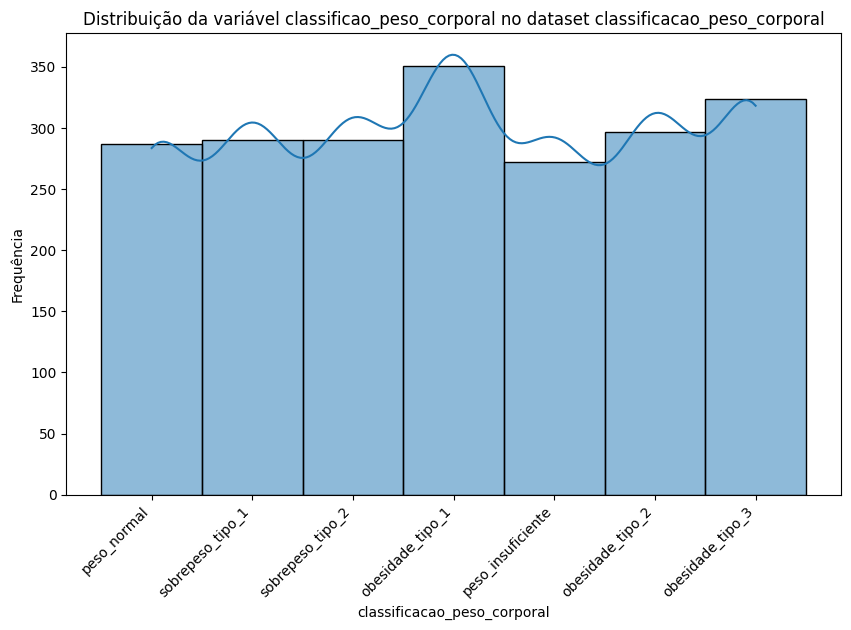

In [238]:
titulo_histograma_classificacao_peso_corporal = 'Distribuição da variável classificao_peso_corporal no dataset classificacao_peso_corporal'
histograma_classificacao_peso_corporal = gera_histograma(df, 'classificacao_peso_corporal', titulo_histograma_classificacao_peso_corporal)

### **nivel_obesidade por genero**

In [239]:
# Agrupar por classificacao_peso_corporal e contar a ocorrência de cada gênero
classificao_peso_corporal_genero_counts = round(df.groupby('classificacao_peso_corporal')['genero'].value_counts(normalize=True).mul(100).reset_index(name='porcentagem'),2)

# Pivotar a tabela para ter as quantidades de feminino e masculino como colunas
classificao_peso_corporal_genero_pivot = classificao_peso_corporal_genero_counts.pivot(index='classificacao_peso_corporal', columns='genero', values='porcentagem').reset_index()

# Renomear as colunas 0 and 1 to 'qtde_feminino' and 'qtde_masculino'
# based on the encoded gender values (assuming 0 is Female and 1 is Male)
classificao_peso_corporal_genero_pivot.rename(columns={0: 'qtde_feminino', 1: 'qtde_masculino'}, inplace=True)


# Converter a coluna 'classificacao_peso_corporal' para tipo categórico com a ordem definida
classificao_peso_corporal_genero_pivot['classificacao_peso_corporal'] = pd.Categorical(
    classificao_peso_corporal_genero_pivot['classificacao_peso_corporal'],
    categories=ordem_classificao_peso_corporal,
    ordered=True
)

# Ordenar o DataFrame pela ordem das categorias de classificacao_peso_corporal
classificao_peso_corporal_genero_pivot = classificao_peso_corporal_genero_pivot.sort_values('classificacao_peso_corporal').reset_index(drop=True)

# Exibir o novo DataFrame
display(classificao_peso_corporal_genero_pivot)

genero,classificacao_peso_corporal,qtde_feminino,qtde_masculino
0,peso_insuficiente,63.60,36.40
1,peso_normal,49.13,50.87
2,sobrepeso_tipo_1,50.00,50.00
3,sobrepeso_tipo_2,35.52,64.48
4,obesidade_tipo_1,44.44,55.56
5,obesidade_tipo_2,0.67,99.33
6,obesidade_tipo_3,99.69,0.31


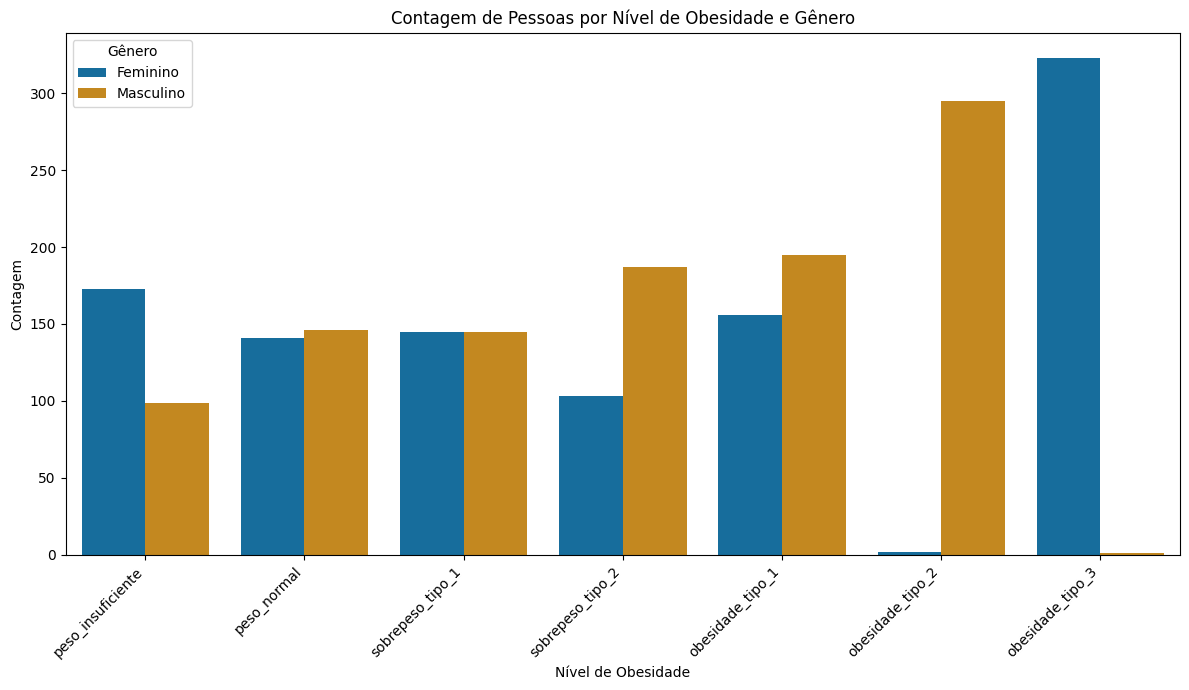

In [240]:
plt.figure(figsize=(12, 7))
# O 'obesidade' coluna no DataFrame df agora contem os valores em português devido a execução da celula wuA3dd51hF-a
sns.countplot(data=df, x='classificacao_peso_corporal', hue='genero', palette='colorblind', order=ordem_classificao_peso_corporal)

plt.xticks(ticks=range(len(ordem_classificao_peso_corporal)), labels=ordem_classificao_peso_corporal, rotation=45, ha='right')


plt.title('Contagem de Pessoas por Nível de Obesidade e Gênero')
plt.xlabel('Nível de Obesidade')
plt.ylabel('Contagem')
plt.legend(title='Gênero', labels=['Feminino', 'Masculino']) # Ajustar rótulos da legenda
plt.tight_layout()
plt.show()

### **Distribuição da variável IMC na base**

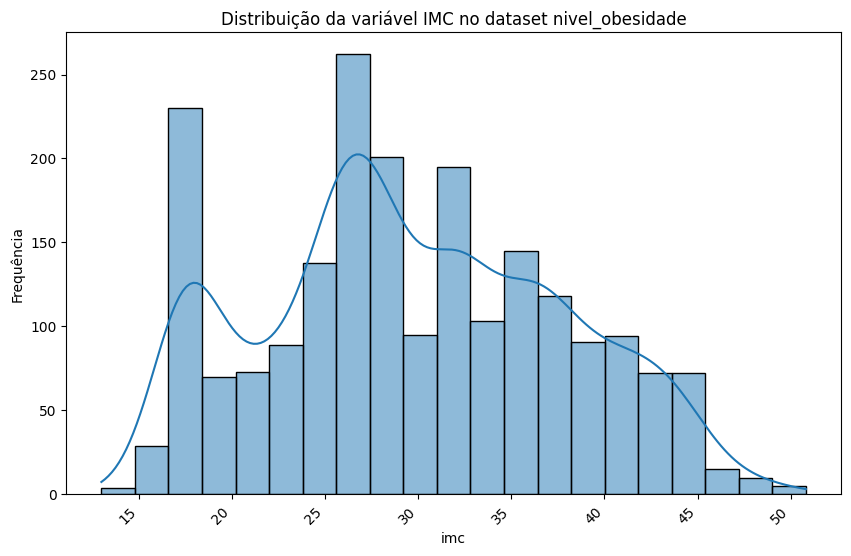

In [241]:
titulo_histograma_imc = 'Distribuição da variável IMC no dataset nivel_obesidade'
histograma_imc = gera_histograma(df, 'imc', titulo_histograma_imc)

## **Contagem de classicao  classificacao imc agrupado por classificacao_peso_corporal**

O intuito foi validar se existiam casos se a coluna classificacao_peso_corporal era apenas uma variacao da classificação de IMC da OMS.

In [243]:
# Agrupar por classificacao_imc e classificacao_peso_corporal e contar as ocorrências
classificacao_agrupada = df.groupby(['classificacao_imc', 'classificacao_peso_corporal']).size().reset_index(name='quantidade')

# Calcular a porcentagem dentro de cada grupo classificacao_imc
classificacao_agrupada['porcentagem'] = classificacao_agrupada.groupby('classificacao_imc')['quantidade'].transform(lambda x: round((x / x.sum()) * 100, 2))

# Criar um dicionário de DataFrames, um para cada valor único em 'classificacao_imc'
dataframes_por_classificacao_imc = {}

for imc_categoria in classificacao_agrupada['classificacao_imc'].unique():
    # Filtrar o DataFrame agrupado para a categoria de IMC atual
    df_categoria = classificacao_agrupada[classificacao_agrupada['classificacao_imc'] == imc_categoria].copy()

    # Remover a coluna 'classificacao_imc' do DataFrame específico da categoria
    df_categoria = df_categoria[['classificacao_peso_corporal', 'quantidade', 'porcentagem']]

    # Opcional: Definir 'classificacao_peso_corporal' como índice para melhor visualização
    # df_categoria.set_index('classificacao_peso_corporal', inplace=True)

    # Armazenar o DataFrame no dicionário
    dataframes_por_classificacao_imc[imc_categoria] = df_categoria

# Iterar sobre o dicionário e exibir cada DataFrame
for categoria, df_cat in dataframes_por_classificacao_imc.items():
    print(f"\nDataFrame para a categoria '{categoria}':")
    display(df_cat)


DataFrame para a categoria 'abaixo_do_peso':


/tmp/ipython-input-1065172607.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  classificacao_agrupada = df.groupby(['classificacao_imc', 'classificacao_peso_corporal']).size().reset_index(name='quantidade')
/tmp/ipython-input-1065172607.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  classificacao_agrupada['porcentagem'] = classificacao_agrupada.groupby('classificacao_imc')['quantidade'].transform(lambda x: round((x / x.sum()) * 100, 2))


,classificacao_peso_corporal,quantidade,porcentagem
0,obesidade_tipo_1,0,0.00
1,obesidade_tipo_2,0,0.00
2,obesidade_tipo_3,0,0.00
3,peso_insuficiente,268,99.26
4,peso_normal,2,0.74
5,sobrepeso_tipo_1,0,0.00
6,sobrepeso_tipo_2,0,0.00



DataFrame para a categoria 'peso_normal':


,classificacao_peso_corporal,quantidade,porcentagem
7,obesidade_tipo_1,0,0.00
8,obesidade_tipo_2,0,0.00
9,obesidade_tipo_3,0,0.00
10,peso_insuficiente,4,1.33
11,peso_normal,285,94.68
12,sobrepeso_tipo_1,12,3.99
13,sobrepeso_tipo_2,0,0.00



DataFrame para a categoria 'sobrepeso':


,classificacao_peso_corporal,quantidade,porcentagem
14,obesidade_tipo_1,2,0.35
15,obesidade_tipo_2,0,0.00
16,obesidade_tipo_3,0,0.00
17,peso_insuficiente,0,0.00
18,peso_normal,0,0.00
19,sobrepeso_tipo_1,278,49.12
20,sobrepeso_tipo_2,286,50.53



DataFrame para a categoria 'obesidade_grau_1':


,classificacao_peso_corporal,quantidade,porcentagem
21,obesidade_tipo_1,346,94.02
22,obesidade_tipo_2,18,4.89
23,obesidade_tipo_3,0,0.00
24,peso_insuficiente,0,0.00
25,peso_normal,0,0.00
26,sobrepeso_tipo_1,0,0.00
27,sobrepeso_tipo_2,4,1.09



DataFrame para a categoria 'obesidade_grau_2':


,classificacao_peso_corporal,quantidade,porcentagem
28,obesidade_tipo_1,3,0.89
29,obesidade_tipo_2,279,82.54
30,obesidade_tipo_3,56,16.57
31,peso_insuficiente,0,0.00
32,peso_normal,0,0.00
33,sobrepeso_tipo_1,0,0.00
34,sobrepeso_tipo_2,0,0.00



DataFrame para a categoria 'obesidade_grau_3':


,classificacao_peso_corporal,quantidade,porcentagem
35,obesidade_tipo_1,0,0.0
36,obesidade_tipo_2,0,0.0
37,obesidade_tipo_3,268,100.0
38,peso_insuficiente,0,0.0
39,peso_normal,0,0.0
40,sobrepeso_tipo_1,0,0.0
41,sobrepeso_tipo_2,0,0.0
